# Creating a movie recommendation engine: preprocessing

Watching movies is a popular pastime that offers relaxation and entertainment, allowing us to dive into new worlds and learn from various perspectives. However, the sheer number of available movies can make it challenging to decide what to watch next. Scrolling through streaming platforms, watching trailers, and checking IMDb ratings can be time-consuming, leaving us feeling frustrated and indecisive. If this situation sounds all too familiar, don't worry! I've got the solution for you: build your own movie recommendation engine designed to simplify your film selection process.

**The Movie Recommendation Engine: Your Personalized Movie Picker**

We will build a movie recommendation engine using AI-based text-similarity techniques to eliminate the need to scroll through endless movie options, watch countless trailers, and research IMDb ratings.  We will use state-of-the-art large foundational language models (LLMs) to provide users with personalized movie suggestions based on movie synopses. Here, we will delve into the details of how the algorithm works, including the user flow and the various methods it employs to find similar movies based on text and image inputs.

## The User Flow:

The user flow can be broken down into several key steps:

1. **Movie Search**:
Users can search for a movie in three distinct ways:
    
    A. *Traditional Full-Text Search:* Users can enter a movie title (e.g., Fight Club) and receive a list of relevant results. This method relies on traditional string matching and is suitable for users who know the exact or partial name of the film they are searching for. This functionality is straightforward and will not be the focus here.
    
    B. *Language Model-Based Document QA:* Users can input a description of a movie (e.g., "Movie where an insomniac descends into madness and starts a series of fight clubs around town"). The algorithm employs a large language model (LLM) to analyze the user's input and find movies that match the description. This method is ideal for users who have a rough idea of the plot of the film they want to watch.
    
    C. *Language Model-Based Text Similarity Search*: By comparing the synopsis of all movies pairwise, users can receive a list of the top-N most similar movies based on pre-computed text similarities. This method enables fast and effortless exploration of similar movies.
    
2. **Similarity Search:**
To enable approaches 1B and 1C, all movie synopsis texts in the database must be embedded. This application is limited to the top 10,000 most popular movies containing only Latin characters to simplify text searches. Given the pre-processed synopsis embeddings, the user's text is embedded, and a similarity search is performed across all pre-computed embeddings in the vector store. This process allows the engine to identify movies with comparable features or themes.
3. **Movie Selection:**
    
    After conducting the search, the user selects a movie from the list of results.
    
4. **Finding Similar Movies:**
    
    Once a movie is selected, the user can explore similar films based on two distinct criteria:
    
    A. *Language Model-Based Text Similarity*: This method, as described in steps 1B and 1C, analyzes movie plots and compares them using an LLM. By identifying textual similarities, the algorithm can suggest films with similar storylines or themes.
    
    B. *Computer Vision-Based Image Similarity*: As an additional bonus feature, our engine can utilize computer vision (CV) technology to compare visual elements of the selected movie, such as posters, movie stills, or crew members' profile pictures. By identifying similarities in visual content, the algorithm can recommend movies with a similar aesthetic or those involving the same actors or directors.
    
5. **Iterative Selection:**
    
    Users can continue to explore and select additional movies, returning to step 2. This process allows them to dive deeper into the world of cinema and discover films they may not have otherwise encountered.


## Data Acquisition and Processing for the Movie Recommendation Engine

To provide accurate and personalized movie recommendations, the engine relies on a variety of data sources and processing techniques. In this section, we will briefly explore the data required for the recommendation engine, as well as the methods used to retrieve and process it.

1. **Movie Information and Media:**
    
    The primary source of detailed movie information is The Movie Database (TMDB) API. This API provides comprehensive movie data, including summarized movie details, as well as movie-related media such as posters, backdrops, and videos.
    
2. **Movie Synopsis:**
    
    To obtain additional detailed movie synopses, we can use one or more of the following sources:
    
    A. IMDb: Movie synopses can be scraped from IMDb, a popular and extensive movie database.
    
    B. The Movie Spoiler: This website ([https://themoviespoiler.com/](https://themoviespoiler.com/)) offers detailed plot summaries for a wide range of movies, making it a valuable resource for our text similarity engine.
    
    C. Wikipedia: Another option is to scrape the "Plot" section from relevant movie Wikipedia pages, which typically provide a comprehensive summary of the film's story.
    
3. **Data Embeddings:**
    
    To enable the comparison of movies based on their textual and visual content, the data obtained from steps 1 and 2 must be embedded. We use the following approaches for this process:
    
    A. Text-Based Embeddings: We are going to use roberta-large-v1 ([https://huggingface.co/sentence-transformers/all-roberta-large-v1](https://huggingface.co/sentence-transformers/all-roberta-large-v1)) to create embeddings for all the textual data, such as movie synopses. OpenAI `ada`-based embeddings do not work particularly well for sentence-to-sentence comparisons.
    
    B. Image-Based Embeddings: For visual content, such as movie posters and stills, a large-scale computer vision model from HuggingFace (specific model to be determined) is used to generate image-based embeddings.
    

The movie recommendation engine relies on a diverse range of data sources and processing techniques to provide accurate and personalized movie suggestions.

## Computing embeddings of chunks and storage in a vector store

We can use a language model to compute embeddings for our input text (chunks). If you're unfamiliar with the concept of embeddings, imagine a pile of colored M&Ms in the middle of your table. Large foundational models have learned the general properties of M&Ms and will move them to different locations on the table based on their color. So you will end up with green M&Ms in one corner, blue in another, and so on. Now imagine we are given a cyan M&M. We've never seen that color before. But we know that cyan is a mix of green and blue, so it can be placed somewhere close to those colors on the table. We can then measure how far away the new cyan M&M is from each other M&M on the table. The closest one will be the most similar and the furthest one will be the most dissimilar.

Instead of M&Ms, we have chunks of documents. And instead of 2 dimensions, like our flat table surface, we have 1,000+ dimensions.


In [1]:
# Import the required packages
import pandas as pd # For dataframes
import json # For JSON files
import numpy as np # For numerical operations

In [2]:
# Load a text file from disk and loop over it line by line and call json.loads() on each line to convert it into a Python dictionary
def load_json_to_dict(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

In [3]:
# The file `tmdb_movie_ids_04_28_2023.json` was downloaded at this date from the weekly TMDB data dump
movies_df = pd.DataFrame(load_json_to_dict('tmdb/tmdb_movie_ids_04_28_2023.json')).set_index('id').sort_values('popularity',ascending=False)
movies_df = movies_df.sort_values('popularity',ascending=False)
movies_df

,adult,original_title,popularity,video
id,,,,
640146,False,Ant-Man and the Wasp: Quantumania,8567.865,False
502356,False,The Super Mario Bros. Movie,6572.614,False
594767,False,Shazam! Fury of the Gods,4274.232,False
76600,False,Avatar: The Way of Water,3365.913,False
948713,False,The Last Kingdom: Seven Kings Must Die,3119.049,False
...,...,...,...,...
1119098,False,Ichi-go-ichi-e: First and Last Time,0.000,False
1119099,False,Raghavendra Stores,0.000,False
1119101,False,STANDOFF.,0.000,False


In [5]:
# List movies with non-ascii (likely non-Latin-languaged) titles
# Quick glance of the titles shows that they are mostly non-English-speaking movies
movies_df[~movies_df['original_title'].apply(lambda x: x.isascii())]

,adult,original_title,popularity,video
id,,,,
1008005,False,La niña de la comunión,1154.300,False
849869,False,길복순,958.517,False
876792,False,劇場版 転生したらスライムだった件 紅蓮の絆編,581.249,False
1073413,False,Fenómenas,421.706,False
1071806,False,คนหิว เกมกระหาย,410.982,False
...,...,...,...,...
1119081,False,Viciados Anônimos,0.000,False
1119089,False,Endlich Witwer - Über alle Berge,0.000,False
1119090,False,Frankelda y el Príncipe de los Sustos,0.000,False


In [6]:
# Filter out movies (original_title) that are likely not in English based on their character set
movies_anglic_df = movies_df[movies_df['original_title'].apply(lambda x: x.isascii())]
movies_anglic_df

,adult,original_title,popularity,video
id,,,,
640146,False,Ant-Man and the Wasp: Quantumania,8567.865,False
502356,False,The Super Mario Bros. Movie,6572.614,False
594767,False,Shazam! Fury of the Gods,4274.232,False
76600,False,Avatar: The Way of Water,3365.913,False
948713,False,The Last Kingdom: Seven Kings Must Die,3119.049,False
...,...,...,...,...
1119098,False,Ichi-go-ichi-e: First and Last Time,0.000,False
1119099,False,Raghavendra Stores,0.000,False
1119101,False,STANDOFF.,0.000,False


In [7]:
# Keep top 10k movies based on popularity
movies_top10k_df = movies_anglic_df.iloc[0:10000]
movies_top10k_df

,adult,original_title,popularity,video
id,,,,
640146,False,Ant-Man and the Wasp: Quantumania,8567.865,False
502356,False,The Super Mario Bros. Movie,6572.614,False
594767,False,Shazam! Fury of the Gods,4274.232,False
76600,False,Avatar: The Way of Water,3365.913,False
948713,False,The Last Kingdom: Seven Kings Must Die,3119.049,False
...,...,...,...,...
563710,False,Angela's Christmas,10.753,False
345923,False,All I See Is You,10.753,False
10729,False,Quick Change,10.752,False


## Retrieving the metadata for the top-10K movies

To acquire the full synopsis and metadata for the top 10,000 movies, we need to query the TMDB API 10,000 times and temporarily store the results. It is essential to note that permanently storing the data or using it for purposes beyond transient data processing is against TMDB's terms of service.

We are committed to using the TMDB API data responsibly and in compliance with their terms of service. We will not store or use the data for any purpose other than to compute embeddings. TMDB is an invaluable public resource, available free of charge for non-commercial applications, and we will honor their terms of service by using the data in a manner consistent with their guidelines.


In [10]:
import asyncio # For asynchronous programming
import aiohttp # For asynchronous HTTP requests
import json # For JSON files
from fake_useragent import UserAgent # For generating fake user agents
import random # For generating random numbers
import os # For file operations

In [11]:
API_KEY = "YOUR_API_KEY" # Your TMDB API key
MOVIE_IDS = movies_top10k_df.index.tolist()  # Replace with your list of movie IDs

In [74]:
# Function to fetch the movie data for a given TMDB movie ID
async def fetch_movie(session, movie_id):
    # Construct the URL for the movie using the movie ID and API Key
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={API_KEY}"
    
    # Generate a random user agent for the request header
    # We do this to simulate different users making the requests and to avoid rate limiting
    # See https://developers.themoviedb.org/3/getting-started/request-rate-limiting
    headers = {"User-Agent": UserAgent().random}

    # Make an asynchronous GET request to fetch the movie data
    # If we receive a response with a status code of 200 (OK), return the JSON data
    # Otherwise, print an error message and return None
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            # If the request is successful, get the JSON data
            movie_data = await response.json()
            return movie_data
        else:
            print(f"Error fetching movie with ID {movie_id}: {response.status}")
            return None

# Function to fetch and store the movie data for a given movie ID
async def fetch_and_store_movie(movie_id):
    # Check if the file already exists
    file_path = f"movie_{movie_id}.json"
    # If the file already exists, print a message and return True
    # This is to avoid making unnecessary API calls and to speed up the process
    if os.path.exists(file_path):
        print(f"File for movie ID {movie_id} already exists. Skipping...")
        # Return True if the file already exists
        return True

    # Create an aiohttp client session for fetching the movie data
    async with aiohttp.ClientSession() as session:
        movie_data = await fetch_movie(session, movie_id)
        if movie_data:
            # Store the movie data as a JSON file
            with open(file_path, "w") as file:
                json.dump(movie_data, file)
            print(f"Stored movie data for ID {movie_id}")
        else:
            # If movie_data is None, add movie_id to the list of failed_movie_ids
            failed_movie_ids.append(movie_id)

    # Return False if the file did not exist and the movie data was fetched
    return False

# Main function to control the execution flow
async def main():
    # Define rate limit, delay between calls, and random delay variance
    rate_limit = 3
    delay_between_calls = 1 / rate_limit
    random_delay_variance = 0.1

    # Loop through the list of movie IDs
    for movie_id in MOVIE_IDS:
        # Call fetch_and_store_movie and get the result indicating if the file already exists
        file_exists = await fetch_and_store_movie(movie_id)
        
        # Only wait for the next API call if the file does not exist
        if not file_exists:
            await asyncio.sleep(delay_between_calls + random.uniform(-random_delay_variance, random_delay_variance))

    # Print the list of failed movie IDs
    print("Failed to fetch the following movie IDs:", failed_movie_ids)

# Initialize the list of failed movie IDs outside the main function
failed_movie_ids = []

In [ ]:
# Depending on how successful you are. You may need to run this multiple times to get all the data.
# Since we skip existing files, we can run this multiple times without worrying about overwriting existing data and
# it will run faster each time since we will have already fetched the data for some movies
await main()

In [76]:
failed_movie_ids

[]

In [12]:
import glob # For finding files using wildcards

In [14]:
# Load a text file from disk and loop over it line by line and call json.loads() on each line to convert it into a Python dictionary
def load_json_files_to_dict(file_paths):
    data = []
    for path in file_paths:
        with open(path, 'r') as f:
            data.append(json.loads(f.read()))
    return data

In [15]:
# Load all the individual movie JSON files into a single DataFrame
movies_top10k_complete_df = pd.DataFrame(load_json_files_to_dict(glob.glob("movie_*.json"))).set_index('id').loc[movies_top10k_df.index]
movies_top10k_complete_df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,,,
640146,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.marvel.com/movies/ant-man-and-the-...,tt10954600,en,Ant-Man and the Wasp: Quantumania,Super-Hero partners Scott Lang and Hope van Dy...,...,2023-02-15,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906
502356,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",https://www.thesupermariobros.movie,tt6718170,en,The Super Mario Bros. Movie,"While working underground to fix a water main,...",...,2023-04-05,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483
594767,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",,tt10151854,en,Shazam! Fury of the Gods,"Billy Batson and his foster siblings, who tran...",...,2023-03-15,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253
76600,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.avatar.com/movies/avatar-the-way-o...,tt1630029,en,Avatar: The Way of Water,Set more than a decade after the events of the...,...,2022-12-14,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556
948713,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.netflix.com/title/81460361,tt15767808,en,The Last Kingdom: Seven Kings Must Die,"In the wake of King Edward's death, Uhtred of ...",...,2023-04-14,0,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563710,False,/8uj9vrZtZHJKIyYEKH6DuU0B6Sr.jpg,"{'id': 766198, 'name': 'Angela's Christmas Col...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",,tt7829544,en,Angela's Christmas,A trip to church with her family on Christmas ...,...,2017-12-02,0,30,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Angela's Christmas,False,6.831,201
345923,False,/daBjwNXK5eZ0BYU9IAUcG7j5SJF.jpg,None,30000000,"[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '...",http://www.alliseeisyoumovie.com/,tt4486986,en,All I See Is You,A blind woman's relationship with her husband ...,...,2017-08-10,646946,110,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,An obsessive love story.,All I See Is You,False,5.154,521
10729,False,/xd7GlVVQ53P53LN9bD6yHiF52cA.jpg,None,15000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",https://www.warnerbros.com/movies/quick-change/,tt0100449,en,Quick Change,"With the aid of his girlfriend, Phyllis Potter...",...,1990-07-13,15260154,89,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The bank robbery was easy. But getting out of ...,Quick Change,False,6.701,299


## Acquiring Movie Synopses from IMDb Using TMDB Metadata

With the IMDb identifiers acquired through the TMDB metadata, we can retrieve the synopses for all 10,000 movies from IMDb. To ensure responsible web scraping, we will implement two strategies:

1. Rate Limiting Requests: By controlling the frequency of our requests to IMDb, we can prevent overloading their servers and reduce the risk of our IP address being banned. This approach demonstrates responsible web scraping practices and shows respect for the target website's resources. We will submit requests every 1/3 of a second plus-minus some random time between 0-100 milliseconds.

2. Random User Agents: To simulate different browsers and further minimize the likelihood of encountering issues during the scraping process, we will use random user agents. This technique enhances the diversity of our requests, making them appear as if they originate from various browsers and devices.

In [19]:
# Import necessary libraries
import asyncio
import aiohttp
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import random
from readability import Document

# Replace with your list of IMDb IDs
IMDB_IDS = movies_top10k_complete_df.imdb_id.to_list()

# Function to fetch the IMDb page for a given IMDb ID
async def fetch_imdb_page(session, imdb_id):
    # Construct the URL for the IMDb page using the IMDb ID
    url = f'https://www.imdb.com/title/{imdb_id}/plotsummary'
    
    # Generate a random user agent for the request header
    headers = {'User-Agent': UserAgent().random}

    # Make an asynchronous GET request to fetch the IMDb page
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            # If the request is successful, get the HTML content
            html_content = await response.text()
            return html_content
        else:
            print(f'Error fetching IMDb page for ID {imdb_id}: {response.status}')
            return None

# Function to fetch and store the synopsis for a given IMDb ID
async def fetch_and_store_synopsis(imdb_id):
    # Create an aiohttp client session for fetching the IMDb page
    async with aiohttp.ClientSession() as session:
        html_content = await fetch_imdb_page(session, imdb_id)
        if html_content:
            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(html_content, 'lxml')
            
            # Use the readability module to extract a readable version of the synopsis
            readable_article = Document(soup.prettify()).summary()
            soup_readable_article = BeautifulSoup(readable_article, 'lxml')

            # Store the synopsis (e.g., save to an HTML file)
            with open(f'synopsis_{imdb_id}.html', 'w') as file:
                file.write(soup_readable_article.prettify())
            print(f'Stored synopsis for IMDb ID {imdb_id}')

# Main function to control the execution flow
async def main():
    # Define rate limit, delay between calls, and random delay variance
    rate_limit = 3
    delay_between_calls = 1 / rate_limit
    random_delay_variance = 0.1

    # Loop through the list of IMDb IDs
    for imdb_id in IMDB_IDS:
        # Call fetch_and_store_synopsis for each IMDb ID
        await fetch_and_store_synopsis(imdb_id)
        
        # Wait for a random duration before making the next API call
        await asyncio.sleep(delay_between_calls + random.uniform(-random_delay_variance, random_delay_variance))

In [ ]:
# Depending on how successful you are. You may need to run this multiple times to get all the data.
# Since we skip existing files, we can run this multiple times without worrying about overwriting existing data and
# it will run faster each time since we will have already fetched the data for some movies
# Runetime is about 200 minutes
await main()

In [21]:
synopsis_docs = glob.glob("synopsis_*.html")
len(synopsis_docs)

9797

In [26]:
import re
from bs4 import BeautifulSoup

def extract_plain_text_from_html(file_path):
    with open(file_path, 'r') as file:
        html_content = file.read()

    soup = BeautifulSoup(html_content, 'lxml')

    # Replace <p> tags with new lines
    for p_tag in soup.find_all('p'):
        p_tag.replace_with(f'\n{p_tag.text}')

    # Extract plain text from the modified soup
    plain_text = soup.get_text()

    # Remove any remaining tags within angle brackets
    plain_text = re.sub('<[^>]*>', '', plain_text)

    # Replace multiple newlines and whitespace with a single newline
    plain_text = re.sub('\n\s*\n', '\n', plain_text).strip()

    # Replace multiple spaces with a single space
    plain_text = re.sub(' +', ' ', plain_text)

    return plain_text

In [31]:
imdb_synopsis = pd.DataFrame({'text': [extract_plain_text_from_html(s) for s in synopsis_docs]}, index=[s.replace('synopsis_', '').replace('.html', '') for s in synopsis_docs])
imdb_synopsis['characters'] = imdb_synopsis.text.str.len()
imdb_synopsis

,text,characters
tt0372237,Percy and Marilyn are renewing their vows for ...,699
tt0211181,Reformed and recently released from prison aft...,756
tt2418558,Gwendolyn Shepherd is a regular 16-year-old gi...,952
tt5078204,A bachelor enjoys his sweet life on the French...,193
tt7531096,A loyal dog and a vigilante cat embark on a sp...,84
...,...,...
tt3612032,"Two bikers, Daria and Nick, ride their bikes d...",1985
tt5638642,"Five old friends from university--Phil, Dom, H...",7329
tt5164214,The film starts with Debbie Ocean (Sandra Bull...,7444
tt0469111,"In a small Colorado town, Amber Williams (Broo...",4315


In [32]:
imdb_synopsis.sort_values('characters', ascending=False)

,text,characters
tt0144084,A white background. Red drops begin to fall pa...,64012
tt1345836,Commissioner James Gordon (\n Gary Oldman\n ) ...,59883
tt0399201,The Island begins with a montage of dream scen...,59251
tt0103064,Scenes described in red text appear only in th...,58761
tt0120912,The Columbia torch buzzes then flashes like a ...,57236
...,...,...
tt9224104,Plot unknown. Sequel to the 2018 film 'The Meg'.,48
tt9663764,Plot unknown. Sequel to the 2018 film 'Aquaman.',48
tt21983602,Lisa is convinced to become a Disney princess.,46
tt10160976,Sequel to the 2018 hit film --- The Nun.,40


In [33]:
# As a quick test: split imdb_synopsis.text into chunks of 1000 characters
imdb_synopsis['chunks'] = imdb_synopsis.text.str.replace('\n', '').str.replace(' ', '').str.len() // 1000 + 1

<Axes: >

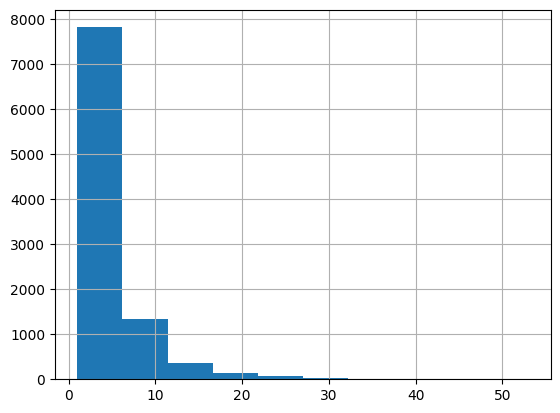

In [35]:
# Plot the distribution of number of chunks with a granularity of 1
imdb_synopsis.chunks.value_counts().sort_index().plot.bar()

In [54]:
# Do an outer join on the two dataframes based on the imdb_id data
movies_top10k_imdb_df = pd.concat([imdb_synopsis, movies_top10k_complete_df[~movies_top10k_complete_df.imdb_id.duplicated()].reset_index(drop=False).set_index('imdb_id')],axis=1)
movies_top10k_imdb_df = movies_top10k_imdb_df.sort_values('popularity', ascending=False)
movies_top10k_imdb_df

,text,characters,chunks,id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,640146,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.marvel.com/movies/ant-man-and-the-...,...,2023-02-15,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906
tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,502356,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",https://www.thesupermariobros.movie,...,2023-04-05,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483
tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,594767,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",,...,2023-03-15,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253
tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,76600,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.avatar.com/movies/avatar-the-way-o...,...,2022-12-14,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556
tt15767808,"Anlaf, a Viking king from Ireland, arrives wit...",4375.0,4.0,948713,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.netflix.com/title/81460361,...,2023-04-14,0,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0048554,A tributary of the upper Amazon. A small boat ...,9088.0,8.0,40761,False,/uqnsM7TlWDBVeJyHKUSUfNkxuZm.jpg,"{'id': 221537, 'name': 'Creature From The Blac...",0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",,...,1955-05-13,1100000,82,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,All New Thrills! Shocks! Suspense!,Revenge of the Creature,False,5.800,112
tt4400994,When cowboy Lefty Brown witnesses the murder o...,828.0,1.0,438457,False,/1BNnnrwOPRAJER3tzAKU659cpYY.jpg,None,8000000,"[{'id': 37, 'name': 'Western'}]",http://leftybrownmovie.com,...,2017-12-15,7856,105,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,He never wanted to be the hero,The Ballad of Lefty Brown,False,6.313,155
tt0091647,French anthropologist Jean Charles Pommier die...,3304.0,3.0,26725,False,/f0aKdbxNRcUX4YrTSN3s06w8fMz.jpg,None,2278264,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",,...,1986-03-07,0,89,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A terrifying story of the supernatural,Nomads,False,4.900,89
tt0066412,"Newly married to an older man, Julie returns t...",608.0,1.0,30903,False,/h6jNheRQAdwnJ2i3w6qQMYu3Lh2.jpg,None,0,"[{'id': 27, 'name': 'Horror'}, {'id': 80, 'nam...",,...,1971-01-15,0,98,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,Always unheard… unseen… until he reached out t...,The Strange Vice of Mrs Wardh,False,6.827,127


## Acquiring Movie Plot Summaries from Wikipedia Using TMDB Metadata

After obtaining the TMDB metadata for the top 10,000 movies, we can also acquire their plot summaries from Wikipedia. In this section, we will search Wikipedia for movie titles from the TMDB metadata, and if there is a hit, scrape the "Plot" section while adhering to responsible web scraping practices. We will employ an approach identical to the one above for IMDb.

In [144]:
import wikipediaapi

def get_wikipedia_movie_plot(movie_name, lang='en', append=''):
    # Initialize Wikipedia API with the desired language
    wiki = wikipediaapi.Wikipedia(lang)

    # Search for the movie page
    search_query = movie_name
    if append:
        search_query += append
    
    movie_page = wiki.page(search_query)

    # Check if the page exists
    try:
        if movie_page.exists():
            # Extract the sections from the page
            sections = movie_page.sections

            # Find the "Plot" section
            plot_section = None
            for section in sections:
                if "".join(section.title.lower().split()) == 'plot':
                    plot_section = section
                    break

            # If the "Plot" section is found, loop through its subsections and concatenate their text
            if plot_section:
                plot_text = plot_section.text
                for subsection in plot_section.sections:
                    plot_text += subsection.title + ":\n" + subsection.text + "\n"
                return plot_text
            else:
                # print(f'No "Plot" section found for movie: {movie_name}')
                return None
        else:
            # print(f'No Wikipedia page found for movie: {movie_name}')
            return None
    except Exception as e:
        print('Failed with error:', e)
        return None


In [145]:
movies_top10k_imdb_df['release_year'] = [a.split('-')[0] for a in movies_top10k_imdb_df.release_date]

In [148]:
# Some will fail like "The Whale (2022 film)" which cannot be found with the search
# "The Whale (film)" as it cannot be disambiguated from "The Whale (2013 film)" etc.
# Same thing for "Dune (2021 film)" since there are multiple films with the same name.
# We try to get around this by appending either "(film)" or "({release_year} film)" to 
# the search query. This will not work for all movies, but it will work for most.
import tqdm
wikipedia_plots = {}
wikipedia_failed = []

for id,row in tqdm.tqdm(movies_top10k_imdb_df[~movies_top10k_imdb_df.id.isin(wikipedia_failed + wp.index.to_list())].iterrows()):
    plot_text = get_wikipedia_movie_plot(row.title)
    if plot_text:
        wikipedia_plots[row.id] = plot_text
    else:
        plot_text = get_wikipedia_movie_plot(row.title,append=' (film)')
        if plot_text:
            wikipedia_plots[row.id] = plot_text
        else:
            plot_text = get_wikipedia_movie_plot(row.title,append=f' ({row.release_year} film)')
            if plot_text:
                wikipedia_plots[row.id] = plot_text
            else:
                wikipedia_failed.append(row.id)


702it [08:44,  1.26it/s]

Failed with error: 'pages'
Failed with error: 'pages'


703it [08:45,  1.34it/s]

Failed with error: 'pages'


4278it [49:09,  1.38it/s]

Failed with error: 'pages'
Failed with error: 'pages'


4279it [49:10,  1.42it/s]

Failed with error: 'pages'


6455it [1:15:07,  1.43it/s]


In [ ]:
wikipedia = pd.DataFrame(wikipedia_plots,index=['synopsis']).T
wikipedia

In [159]:
# Rename the column as wikiepedia_synopsis to disambiuate it from the imdb synopsis
wikipedia.columns = ['wikipedia_synopsis']

In [155]:
movies_top10k_imdb_df = movies_top10k_imdb_df.reset_index(drop=False).set_index('id')
movies_top10k_imdb_df

,index,text,characters,chunks,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year
id,,,,,,,,,,,,,,,,,,,,,
640146,tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.marvel.com/movies/ant-man-and-the-...,...,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906,2023
502356,tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",https://www.thesupermariobros.movie,...,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483,2023
594767,tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",,...,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253,2023
76600,tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.avatar.com/movies/avatar-the-way-o...,...,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556,2022
948713,tt15767808,"Anlaf, a Viking king from Ireland, arrives wit...",4375.0,4.0,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.netflix.com/title/81460361,...,0,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40761,tt0048554,A tributary of the upper Amazon. A small boat ...,9088.0,8.0,False,/uqnsM7TlWDBVeJyHKUSUfNkxuZm.jpg,"{'id': 221537, 'name': 'Creature From The Blac...",0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",,...,1100000,82,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,All New Thrills! Shocks! Suspense!,Revenge of the Creature,False,5.800,112,1955
438457,tt4400994,When cowboy Lefty Brown witnesses the murder o...,828.0,1.0,False,/1BNnnrwOPRAJER3tzAKU659cpYY.jpg,None,8000000,"[{'id': 37, 'name': 'Western'}]",http://leftybrownmovie.com,...,7856,105,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,He never wanted to be the hero,The Ballad of Lefty Brown,False,6.313,155,2017
26725,tt0091647,French anthropologist Jean Charles Pommier die...,3304.0,3.0,False,/f0aKdbxNRcUX4YrTSN3s06w8fMz.jpg,None,2278264,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",,...,0,89,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A terrifying story of the supernatural,Nomads,False,4.900,89,1986


In [161]:
# Concatenate our results from IMDB + TMDB with the Wikipedia synopsis results
movies_top10k_imdb_wikipedia_df = pd.concat([wikipedia, movies_top10k_imdb_df],axis=1)
movies_top10k_imdb_wikipedia_df

,wikipedia_synopsis,index,text,characters,chunks,adult,backdrop_path,belongs_to_collection,budget,genres,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year
640146,During her days of entrapment in the Quantum R...,tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906,2023
502356,Italian-American brothers Mario and Luigi have...,tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",...,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483,2023
594767,"Two years after Thaddeus Sivana's defeat, Hesp...",tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",...,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253,2023
76600,Sixteen years after the Na'vi repelled the RDA...,tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",...,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556,2022
948713,"Anlaf, a Viking king from Irland, arrives with...",tt15767808,"Anlaf, a Viking king from Ireland, arrives wit...",4375.0,4.0,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,0,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329829,NaN,tt1254322,"At age six in 1632 upon his death, Kristina, t...",1545.0,2.0,False,/27GTXoyC8PN2INga6zCAZP1TkJm.jpg,None,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",...,0,106,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,The Girl King,False,6.300,151,2015
74658,NaN,tt1618450,The King and Queen of Sparks and Bloom's biolo...,182.0,1.0,False,/apedEXmc9wSiphdi7JenkB8hCJR.jpg,"{'id': 115708, 'name': 'Winx Club Collection',...",35000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",...,11583758,87,"[{'english_name': 'Dutch', 'iso_639_1': 'nl', ...",Released,,Winx Club - Magic Adventure,False,6.900,100,2010
408509,NaN,tt4746516,Four different instances in the life of the sa...,1426.0,2.0,False,/1MIs5fcBZ2F8f2tK98L6DxYtP4v.jpg,None,0,"[{'id': 18, 'name': 'Drama'}]",...,0,111,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Orphan,False,5.280,82,2017
334354,NaN,tt3849938,It is the summer holiday and Mika once again h...,1077.0,1.0,False,/fPjsLSiD8iXhLX3PaR8USs5Cxkh.jpg,"{'id': 334414, 'name': 'Windstorm Collection',...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",...,0,103,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,Windstorm 2,False,7.401,191,2015


In [165]:
# Save the dataframes to disk
movies_top10k_imdb_wikipedia_df.to_parquet('tmdb_top10k_imdb_wikipedia.pq',compression='zstd',compression_level=21)

## Acquiring User-Submitted Synopses from The Movie Spoiler Website Using TMDB Metadata

After obtaining the TMDB metadata for the top 10,000 movies, we can also acquire user-submitted synopses from The Movie Spoiler website. We will proceed exactly as for IMDB above.

In [187]:
import requests
from bs4 import BeautifulSoup

url = 'https://themoviespoiler.com/'

# Send a GET request to the URL
response = requests.get(url)

# Create a list to store the row data
row_data = []

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the div with the specified id
    target_div = soup.find('div', {'id': 'enhancedtextwidget-3'})

    if target_div:
        # Find the first table within the div
        first_table = target_div.find('table')

        if first_table:
            # Extract the tbody element
            tbody = first_table.find('tbody')

            # Extract all the rows (tr elements) from the tbody
            rows = tbody.find_all('tr')

            # Loop through the rows
            for row in rows:
                # Extract the cells (td elements) from the row
                cells = row.find_all('td')

                # Extract the first link and its href and text from the cells and store them in a list
                cell_data = []
                for cell in cells:
                    first_link = cell.find('a')
                    if first_link:
                        cell_data.append({'text': first_link.get_text(strip=True), 'url': first_link['href']})
                row_data.append(cell_data)

        else:
            print("No table found inside the div.")
    else:
        print("Div with the specified id not found.")
else:
    print(f"Request failed with status code {response.status_code}")


In [188]:
# Deduplicate the dictionaries based on the 'link' key
unique_list = list({item['url']: item for item in [item for sublist in row_data for item in sublist]}.values())

In [191]:
# All unqiue movies available on the website
themoviespoiler_df = pd.DataFrame(unique_list)
themoviespoiler_df

,text,url
0,GHOSTED,https://themoviespoiler.com/movies/ghosted/
1,EVIL DEAD RISE,https://themoviespoiler.com/movies/evil-dead-r...
2,BEAU IS AFRAID,https://themoviespoiler.com/movies/beau-is-afr...
3,SUZUME,https://themoviespoiler.com/movies/suzume/
4,RENFIELD,https://themoviespoiler.com/movies/renfield/
...,...,...
1412,Godzilla (2014),2014Spoilers/Godzilla.html
1413,The Other Woman,2014Spoilers/OtherWoman.html
1414,Blended,2014Spoilers/Blended.html
1415,Belle,2014Spoilers/belle.html


In [233]:
# Transform movie titles to lowercase and then join our dataframe so far with these urls
x = movies_top10k_imdb_wikipedia_df[movies_top10k_imdb_wikipedia_df.title.str.lower().isin(themoviespoiler_df.text.str.lower())].reset_index(drop=False).set_index('title')
x.index = x.index.str.lower()
x = x[~x.index.duplicated()]
y = themoviespoiler_df[themoviespoiler_df.text.str.lower().isin(movies_top10k_imdb_wikipedia_df.title.str.lower())].set_index('text')
y.index = y.index.str.lower()
y = y[~y.index.duplicated()]
themoviespoiler_valid_df = pd.concat([x,y],axis=1)
themoviespoiler_valid_df

,level_0,wikipedia_synopsis,index,text,characters,chunks,adult,backdrop_path,belongs_to_collection,budget,...,revenue,runtime,spoken_languages,status,tagline,video,vote_average,vote_count,release_year,url
ant-man and the wasp: quantumania,640146,During her days of entrapment in the Quantum R...,tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,...,473237851,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,False,6.524,1906,2023,https://themoviespoiler.com/movies/ant-man-and...
the super mario bros. movie,502356,Italian-American brothers Mario and Luigi have...,tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,...,891438061,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,False,7.517,1483,2023,https://themoviespoiler.com/movies/the-super-m...
shazam! fury of the gods,594767,"Two years after Thaddeus Sivana's defeat, Hesp...",tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,...,132128334,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,False,6.860,1253,2023,https://themoviespoiler.com/movies/shazam-fury...
avatar: the way of water,76600,Sixteen years after the Na'vi repelled the RDA...,tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,...,2312335665,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,False,7.720,7556,2022,https://themoviespoiler.com/movies/avatar-the-...
creed iii,677179,"In 2002 Los Angeles, a young Adonis ""Donnie"" C...",tt11145118,"In 2002 Los Angeles, a young Adonis ""Donnie"" C...",4095.0,4.0,False,/5i6SjyDbDWqyun8klUuCxrlFbyw.jpg,"{'id': 553717, 'name': 'Creed Collection', 'po...",75000000,...,269000000,116,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,You can't run from your past.,False,7.281,1197,2023,https://themoviespoiler.com/movies/creed-iii/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
possessor uncut,435615,NaN,tt5918982,"In an alternate 2008, Tasya Vos is an assassin...",3206.0,3.0,False,/1DWIdrj8Qga8N3JaDYjJ8z59k2F.jpg,None,0,...,841334,104,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,No body is safe.,False,6.344,665,2020,https://themoviespoiler.com/movies/possessor-u...
lost girls,567970,NaN,tt3111426,When Mari Gilbert's (Academy Award® nominee Am...,500.0,1.0,False,/vwkJChYb9dBcuds98Se4oHIcbnw.jpg,None,0,...,0,95,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,False,6.102,622,2020,https://themoviespoiler.com/movies/lost-girls/
mr. right,333385,NaN,tt2091935,Martha (Anna Kendrick) is home at her apartmen...,4964.0,5.0,False,/f2FOPlspPGm0ZPLxd5DEXCYEkGZ.jpg,None,8000000,...,34694,95,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They make a killer couple.,False,6.466,1189,2016,2016Spoilers/MrRight.html
thoroughbreds,397722,NaN,tt5649108,"The movie opens with a young woman, Amanda (Ol...",4681.0,4.0,False,/99Rd26ceIhonpOP5JoqcXYqnkD.jpg,None,0,...,2830775,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Good breeding gone bad,False,6.400,1005,2018,2018Spoilers/Thoroughbreds.html


In [236]:
from urllib.parse import urljoin

base_url = 'https://themoviespoiler.com/'
# Prepend the base URL to any relative URLs
updated_url_list = [urljoin(base_url, url) for url in themoviespoiler_valid_df.url.to_list()]

In [270]:
# Corrected URLs (in cases where some links are relative)
themoviespoiler_valid_df['updated_url'] = updated_url_list

In [244]:
import asyncio
import aiohttp
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from readability import Document

async def fetch_page(session, url):
    # headers = {'User-Agent': UserAgent().random}

    async with session.get(url) as response:
        if response.status == 200:
            html_content = await response.text()
            return html_content
        else:
            print(f'Error fetching page for URL {url}: {response.status}')
            return None

async def fetch_and_extract_text(url):
    try:
        async with aiohttp.ClientSession(trust_env = True) as session:
            html_content = await fetch_page(session, url)
            if html_content:
                soup = BeautifulSoup(html_content, 'html.parser')
                readable_article = Document(soup.prettify()).summary()
                soup_readable_article = BeautifulSoup(readable_article, 'html.parser')
                extracted_text = soup_readable_article.get_text()
                return extracted_text
            else:
                return None
    except Exception as e:
        return None

async def main():
    tasks = [fetch_and_extract_text(url) for url in updated_url_list]
    extracted_texts = await asyncio.gather(*tasks)

    # Store the extracted texts in a dictionary with the URLs as keys
    result_dict = {url: text for url, text in zip(updated_url_list, extracted_texts)}

    return result_dict

In [245]:
# Depending on how successful you are. You may need to run this multiple times to get all the data.
# Since we skip existing files, we can run this multiple times without worrying about overwriting existing data and
# it will run faster each time since we will have already fetched the data for some movies
# Runetime is about 200 minutes
moviespoiler_res = await main()

Error fetching page for URL https://themoviespoiler.com/2016Spoilers/KeepingUpWithTheJoneses.html: 404
Error fetching page for URL https://themoviespoiler.com/2016Spoilers/KungFuPanda3.html: 404


In [267]:
# Store the results in a dataframe
moviespoiler_res_df = pd.DataFrame(moviespoiler_res,index=['spoiler']).T
moviespoiler_res_df = moviespoiler_res_df[[s != None for s in moviespoiler_res_df.spoiler]]
moviespoiler_res_df

,spoiler
https://themoviespoiler.com/movies/ant-man-and-the-wasp-quantumania/,\n\n ANT-MAN AND THE WASP: QUANTUMANIA...
https://themoviespoiler.com/movies/the-super-mario-bros-movie/,\n\n THE SUPER MARIO BROS. MOVIE\n ...
https://themoviespoiler.com/movies/shazam-fury-of-the-gods/,\n\n SHAZAM! Fury of the Gods\n ...
https://themoviespoiler.com/movies/avatar-the-way-of-water/,\n\n AVATAR: The Way of Water\n ...
https://themoviespoiler.com/movies/creed-iii/,\n\n CREED III\n \n\n *...
...,...
https://themoviespoiler.com/movies/noelle/,\n\n NOELLE\n \n\n *CUT...
https://themoviespoiler.com/2015Spoilers/The33.html,\n\n\n\n THE 33\n \n\...
https://themoviespoiler.com/movies/i-want-you-back/,\n\n I WANT YOU BACK\n \n\n ...
https://themoviespoiler.com/2018Spoilers/BadSamaritan.html,\n\n\n BAD SAMARITAN\n ...


In [287]:
# Add the unique TMDB movie identifier as the index
spoiler_df = pd.concat([moviespoiler_res_df,themoviespoiler_valid_df[themoviespoiler_valid_df.updated_url.isin(moviespoiler_res_df.index)].reset_index(drop='true').set_index('updated_url')],axis=1)[['level_0','spoiler']].set_index('level_0')
spoiler_df

,spoiler
level_0,
640146,\n\n ANT-MAN AND THE WASP: QUANTUMANIA...
502356,\n\n THE SUPER MARIO BROS. MOVIE\n ...
594767,\n\n SHAZAM! Fury of the Gods\n ...
76600,\n\n AVATAR: The Way of Water\n ...
677179,\n\n CREED III\n \n\n *...
...,...
454467,\n\n NOELLE\n \n\n *CUT...
293646,\n\n\n\n THE 33\n \n\...
680860,\n\n I WANT YOU BACK\n \n\n ...


In [286]:
movies_top10k_imdb_wikipedia_spoilers_df = movies_top10k_imdb_wikipedia_df.copy()
movies_top10k_imdb_wikipedia_spoilers_df['spoiler'] = ''

In [288]:
movies_top10k_imdb_wikipedia_spoilers_df.loc[spoiler_df.index,'spoiler'] = spoiler_df.spoiler

In [289]:
# Have a peek at what we have so far
movies_top10k_imdb_wikipedia_spoilers_df

,wikipedia_synopsis,index,text,characters,chunks,adult,backdrop_path,belongs_to_collection,budget,genres,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year,spoiler
640146,During her days of entrapment in the Quantum R...,tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,"{'id': 422834, 'name': 'Ant-Man Collection', '...",200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906,2023,\n\n ANT-MAN AND THE WASP: QUANTUMANIA...
502356,Italian-American brothers Mario and Luigi have...,tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",...,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483,2023,\n\n THE SUPER MARIO BROS. MOVIE\n ...
594767,"Two years after Thaddeus Sivana's defeat, Hesp...",tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,"{'id': 724848, 'name': 'Shazam! Collection', '...",125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",...,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253,2023,\n\n SHAZAM! Fury of the Gods\n ...
76600,Sixteen years after the Na'vi repelled the RDA...,tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",...,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556,2022,\n\n AVATAR: The Way of Water\n ...
948713,"Anlaf, a Viking king from Irland, arrives with...",tt15767808,"Anlaf, a Viking king from Ireland, arrives wit...",4375.0,4.0,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234,2023,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329829,NaN,tt1254322,"At age six in 1632 upon his death, Kristina, t...",1545.0,2.0,False,/27GTXoyC8PN2INga6zCAZP1TkJm.jpg,None,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",...,106,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,The Girl King,False,6.300,151,2015,
74658,NaN,tt1618450,The King and Queen of Sparks and Bloom's biolo...,182.0,1.0,False,/apedEXmc9wSiphdi7JenkB8hCJR.jpg,"{'id': 115708, 'name': 'Winx Club Collection',...",35000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",...,87,"[{'english_name': 'Dutch', 'iso_639_1': 'nl', ...",Released,,Winx Club - Magic Adventure,False,6.900,100,2010,
408509,NaN,tt4746516,Four different instances in the life of the sa...,1426.0,2.0,False,/1MIs5fcBZ2F8f2tK98L6DxYtP4v.jpg,None,0,"[{'id': 18, 'name': 'Drama'}]",...,111,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Orphan,False,5.280,82,2017,
334354,NaN,tt3849938,It is the summer holiday and Mika once again h...,1077.0,1.0,False,/fPjsLSiD8iXhLX3PaR8USs5Cxkh.jpg,"{'id': 334414, 'name': 'Windstorm Collection',...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",...,103,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,Windstorm 2,False,7.401,191,2015,


In [297]:
# Now we need to extract the plain text from the HTML string
import re
from bs4 import BeautifulSoup

def extract_plain_text_html_string(text):
    soup = BeautifulSoup(text, 'lxml')

    # Replace <p> tags with new lines
    for p_tag in soup.find_all('div#cut-to-the-chase'):
        p_tag.replace_with('')

    # Extract plain text from the modified soup
    plain_text = soup.get_text()

    # Remove any remaining tags within angle brackets
    plain_text = re.sub('<[^>]*>', '', plain_text)

    # Replace multiple newlines and whitespace with a single newline
    plain_text = re.sub('\n\s*\n', '\n', plain_text).strip()

    # Replace multiple spaces with a single space
    plain_text = re.sub(' +', ' ', plain_text)

    return plain_text

In [299]:
# Apply the function above to each text in the spoiler column
movies_top10k_imdb_wikipedia_spoilers_df['spoiler'] = movies_top10k_imdb_wikipedia_spoilers_df.spoiler.apply(extract_plain_text_html_string)

In [300]:
# Save to disk
movies_top10k_imdb_wikipedia_spoilers_df.to_parquet('tmdb_top10k_imdb_wikipedia_spoilers.pq',compression='zstd',compression_level=21)

## Compute embeddings

Having gathered all the required data, including movie synopses from various sources, we can now proceed with generating text embeddings. In this section, we will explain the process of using a large language model (LLM) to compute embeddings for text chunks and the rationale behind the choice of model for this task. In order to create embeddings for all the textual data, such as movie synopses, we will use the 'roberta-large-v1' model (https://huggingface.co/sentence-transformers/all-roberta-large-v1) to generate embeddings for text chunks of up to 1,000 characters.

The choice of the 'roberta-large-v1' model over OpenAI's ada-based embeddings is due to its superior performance in sentence-to-sentence comparisons. OpenAI ada-based embeddings are not really competitive for this task, making the 'roberta-large-v1' model a more suitable option for our movie recommendation engine.



In [ ]:
import pandas as pd
import time
import numpy as np

In [ ]:
# Reload the dataframe from disk, in case we start from here
movies_top10k_imdb_wikipedia_spoilers_df = pd.read_parquet('tmdb_top10k_imdb_wikipedia_spoilers.pq')
movies_top10k_imdb_wikipedia_spoilers_df

,wikipedia_synopsis,index,text,characters,chunks,adult,backdrop_path,belongs_to_collection,budget,genres,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year,spoiler
640146,During her days of entrapment in the Quantum R...,tt10954600,During her days of entrapment in the Quantum R...,3025.0,3.0,False,/gMJngTNfaqCSCqGD4y8lVMZXKDn.jpg,{'backdrop_path': '/2KjtWUBiksmN8LsUouaZnxocu5...,200000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,125,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Witness the beginning of a new dynasty.,Ant-Man and the Wasp: Quantumania,False,6.524,1906,2023,ANT-MAN AND THE WASP: QUANTUMANIA\n *CUT TO TH...
502356,Italian-American brothers Mario and Luigi have...,tt6718170,Italian-American brothers Mario and Luigi have...,2688.0,3.0,False,/iJQIbOPm81fPEGKt5BPuZmfnA54.jpg,None,100000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",...,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Super Mario Bros. Movie,False,7.517,1483,2023,THE SUPER MARIO BROS. MOVIE\n *CUT TO THE CHAS...
594767,"Two years after Thaddeus Sivana's defeat, Hesp...",tt10151854,"Several years after the defeat of Dr. Sivana, ...",14364.0,12.0,False,/wybmSmviUXxlBmX44gtpow5Y9TB.jpg,{'backdrop_path': '/qHvTysanNatrEQECO36iES7U1z...,125000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",...,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Oh. My. Gods.,Shazam! Fury of the Gods,False,6.860,1253,2023,SHAZAM! Fury of the Gods\n *CUT TO THE CHASE*\...
76600,Sixteen years after the Na'vi repelled the RDA...,tt1630029,Over a decade after the events of the first fi...,7104.0,6.0,False,/ovM06PdF3M8wvKb06i4sjW3xoww.jpg,{'backdrop_path': '/iaEsDbQPE45hQU2EGiNjXD2KWu...,350000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",...,192,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Return to Pandora.,Avatar: The Way of Water,False,7.720,7556,2022,AVATAR: The Way of Water\n *CUT TO THE CHASE*\...
948713,"Anlaf, a Viking king from Irland, arrives with...",tt15767808,"Anlaf, a Viking king from Ireland, arrives wit...",4375.0,4.0,False,/xwA90BwZXTh8ke3CVsQlj8EOkFr.jpg,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",...,111,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,The Last Kingdom: Seven Kings Must Die,False,7.382,234,2023,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329829,None,tt1254322,"At age six in 1632 upon his death, Kristina, t...",1545.0,2.0,False,/27GTXoyC8PN2INga6zCAZP1TkJm.jpg,None,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",...,106,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,The Girl King,False,6.300,151,2015,
74658,None,tt1618450,The King and Queen of Sparks and Bloom's biolo...,182.0,1.0,False,/apedEXmc9wSiphdi7JenkB8hCJR.jpg,{'backdrop_path': '/nt2ArMVA14yvfvBdWfp0txK2jw...,35000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",...,87,"[{'english_name': 'Dutch', 'iso_639_1': 'nl', ...",Released,,Winx Club - Magic Adventure,False,6.900,100,2010,
408509,None,tt4746516,Four different instances in the life of the sa...,1426.0,2.0,False,/1MIs5fcBZ2F8f2tK98L6DxYtP4v.jpg,None,0,"[{'id': 18, 'name': 'Drama'}]",...,111,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,,Orphan,False,5.280,82,2017,
334354,None,tt3849938,It is the summer holiday and Mika once again h...,1077.0,1.0,False,/fPjsLSiD8iXhLX3PaR8USs5Cxkh.jpg,{'backdrop_path': '/1UtU6fn5DH2aEdD8b5M4m5ZBvd...,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",...,103,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,,Windstorm 2,False,7.401,191,2015,


In [ ]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(        
    separator = " ",
    chunk_size = 1000,
    chunk_overlap  = 100,
    length_function = len,
)

### Create embeddings for: Movie Spoilers

In [ ]:
# Keep only the movies with spoilers exceeding 1,000 characters
spoilers_over1k_df = movies_top10k_imdb_wikipedia_spoilers_df.spoiler[movies_top10k_imdb_wikipedia_spoilers_df.spoiler.str.len() > 1000].dropna()
spoilers_over1k_df

640146    ANT-MAN AND THE WASP: QUANTUMANIA\n *CUT TO TH...
502356    THE SUPER MARIO BROS. MOVIE\n *CUT TO THE CHAS...
594767    SHAZAM! Fury of the Gods\n *CUT TO THE CHASE*\...
76600     AVATAR: The Way of Water\n *CUT TO THE CHASE*\...
677179    CREED III\n *CUT TO THE CHASE*\n NOTE: This sp...
                                ...                        
454467    NOELLE\n *CUT TO THE CHASE*\n NOTE: This spoil...
293646    THE 33\n NOTE: This spoiler was submitted by\n...
680860    I WANT YOU BACK\n *CUT TO THE CHASE*\n NOTE: T...
467632    BAD SAMARITAN\n *CUT TO THE CHASE*\n NOTE: Thi...
397722    THOROUGHBREDS\n *CUT TO THE CHASE*\n NOTE: Thi...
Name: spoiler, Length: 656, dtype: object

In [ ]:
# Some cleaning regexes
import re
non_standard_quotes = '“”‘’'
standard_quotes = '""\'\''

# Create translation table
trans = str.maketrans(non_standard_quotes, standard_quotes)
pattern = re.compile(r'\n ?\*CUT TO THE CHASE\*\n NOTE: This spoiler was submitted by\n [\w\s]+\n', re.IGNORECASE)

In [ ]:
# A simple function to clean the text given most of the empircally observed patterns we would like to remove
def clean_string(dirty_string):
    return re.sub(r'(?i)NOTE:\sThis spoiler was sent in by [a-zA-Z0-9]+.', '', re.sub(r'This spoiler was submitted by \w+', '', re.sub(r'\s+', ' ', re.sub(r'^[A-Z\s]+[:|  ]', '', re.sub(r'\(([A-Z][a-z]*(\s[A-Z][a-z]*)*)\)', '', pattern.sub('', dirty_string)).translate(trans)).replace("VIDEO *CUT TO THE CHASE* Brought to you by", ""))).replace("*CUT TO THE CHASE* Brought to you by","").replace("*CUT TO THE CHASE*", "")).strip()

In [ ]:
# Before convert all the text to Langchain Documents, we need to keep track of the origin source
# for each text. We will use the metadata field for this purpose
metadatas = [{'document': k} for k in spoilers_over1k_df.index.to_list()]

In [ ]:
# Split the text into chunks of 1,000 characters
texts = text_splitter.create_documents([clean_string(doc) for doc in spoilers_over1k_df.to_list()], metadatas)

In [ ]:
# Number of chunks of text
len(texts)

7365

In [ ]:
# Look at a random one
texts[1024]

Document(page_content="appearing to run and he goes after her, then sees Bruno as some kind of monstrous entity. Later, Arne walks down the road when an officer finds him covered in blood. It is reported that Arne stabbed Bruno to death 22 times. Ed and Lorraine talk to Arne and Debbie while he is in interrogation, and Debbie defends Arne by saying that whatever happened to Bruno could not have been Arne's doing. The Warrens talk to Arne's lawyer about trying to get Arne out of receiving a death sentence by trying to prove that he was influenced by demonic possession to carry out the murder. Arne goes to court and presents the demonic possession claim, leading to him being placed in a psych ward. Ed and Lorraine go over their recordings on David's possessions. Based on family statements, the trouble began five months earlier when the Glatzels first moved into their house. David went to check out the water bed and played on it until the demon broke through the mattress and tried to grab

In [ ]:
# Extract out all the pure text from the Langchain Documents
flat_texts = [doc.page_content for doc in texts]

In [ ]:
# Ascertain we have the same number of texts as we had chunks
len(flat_texts)

7365

In [ ]:
# Given a long array break it into smaller chunks of 100
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
from sentence_transformers import SentenceTransformer
import tqdm.notebook as tqdm
        
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

out = []
# Loop over chunks of 100 text chunks and embed them using the Sentence Transformer model
for chunk in tqdm.tqdm(chunks(flat_texts, 100)):
    embeddings = model.encode(chunk)
    out.append(embeddings)

0it [00:00, ?it/s]

In [ ]:
# Since we get embeddings back in stacks of 100, we need to stack them all together
embeddings_all = np.vstack(out)
embeddings_all

array([[-4.13397737e-02,  4.41368558e-02, -6.94593089e-03, ...,
         6.15181178e-02,  3.75620723e-02,  3.73451449e-02],
       [-2.97738686e-02,  1.39960526e-02, -1.43740792e-02, ...,
         5.42866066e-02,  2.11958066e-02,  5.27515970e-02],
       [-1.06483307e-02,  2.56590433e-02, -3.75178941e-02, ...,
         4.75140736e-02, -2.63196025e-02, -3.55950993e-04],
       ...,
       [-3.39053981e-02, -1.74738411e-02, -5.94324339e-03, ...,
        -2.11393777e-02,  7.69769214e-03,  6.27291994e-03],
       [-4.12426628e-02,  2.12749932e-02, -3.07989083e-02, ...,
         1.85123598e-03,  2.07743775e-02,  3.91637310e-02],
       [-4.52747084e-02, -1.73321478e-02, -1.59116171e-03, ...,
        -1.27873635e-02,  1.22030442e-05,  2.50577703e-02]], dtype=float32)

In [ ]:
# Save the embeddings and the texts to disk
np.savez_compressed(f'embeddings__spoilers__roberta.npz', embedding=embeddings_all.astype(np.float32), texts=texts)

In [ ]:
# Look at a random text chunk
texts[2000]

Document(page_content="Bond kills Ash and the assassins, Madeleine and Mathilde are captured. Bond and Nomi go to Safin's island where he is developing the Heracles poison. Nomi kills Obruchev before Madeleine and Mathilde are recovered and brought to safety. Bond tries to open hatch doors in the facility so the Royal Navy's missiles can destroy the facility, but he is caught in a final fight with Safin, who poisons Bond with nanobots that will specifically target Madeleine and Mathilde. After killing Safin, Bond reopens the hatch doors and resigns himself to his fate to protect Madeleine and Mathilde. He has one last talk with Madeleine, reaffirming their love for one another, and she confirms that Mathilde is his daughter. The missiles then destroy the facility and Bond himself. MI6 honors Bond's memory while Madeleine takes Mathilde to Matera to live in peace, and Madeleine begins to tell Mathilde the true story of her father.", metadata={'document': 370172, 'chunk': 15})

In [ ]:
# Find the most similar text chunks to the one above
pd.DataFrame({'hits': [texts[x].metadata['document'] for x in np.argsort(-embeddings_all.dot(embeddings_all[2000]))]}).drop_duplicates().head(10)

,hits
0,370172
13,206647
20,453405
21,522016
22,829280
24,526896
25,574060
26,254904
31,725201
34,577922


### Create embeddings for: Wikipedia

Exactly as above but for Wikipedia

In [ ]:
wikipedia_valid_df = movies_top10k_imdb_wikipedia_spoilers_df.wikipedia_synopsis.dropna()
wikipedia_valid_df

640146    During her days of entrapment in the Quantum R...
502356    Italian-American brothers Mario and Luigi have...
594767    Two years after Thaddeus Sivana's defeat, Hesp...
76600     Sixteen years after the Na'vi repelled the RDA...
948713    Anlaf, a Viking king from Irland, arrives with...
                                ...                        
300666    Josh is a musically-talented DJ who, after an ...
40761     Having previously survived being riddled with ...
438457    In 1889 Montana, a man stumbles out of a saloo...
26725     Jean-Charles Pommier, a French anthropologist,...
30903     In Vienna, a homicidal maniac is killing women...
Name: wikipedia_synopsis, Length: 8110, dtype: object

In [ ]:
def clean_string(dirty_string):
    return re.sub(r'(?i)NOTE:\sThis spoiler was sent in by [a-zA-Z0-9]+.', '', re.sub(r'This spoiler was submitted by \w+', '', re.sub(r'\s+', ' ', re.sub(r'^[A-Z\s]+[:|  ]', '', re.sub(r'\(([A-Z][a-z]*(\s[A-Z][a-z]*)*)\)', '', pattern.sub('', dirty_string)).translate(trans)).replace("VIDEO *CUT TO THE CHASE* Brought to you by", ""))).replace("*CUT TO THE CHASE* Brought to you by","").replace("*CUT TO THE CHASE*", "")).strip()

In [ ]:
metadatas = [{'document': k} for k in wikipedia_valid_df.index.to_list()]

In [ ]:
texts = text_splitter.create_documents([clean_string(doc) for doc in wikipedia_valid_df.to_list()], metadatas)

In [ ]:
len(texts)

35542

In [ ]:
texts[1024]

Document(page_content='During the 1st century BC, Roman general Mark Antony gives Egyptian queen Cleopatra three bejeweled eggs as a wedding gift to show his devotion. The eggs are lost in time until two are found by a farmer in 1907, but the last one remains lost. In the present day, John Hartley, an FBI agent, is assigned to assist Interpol agent Urvashi Das in investigating the potential theft of one of the eggs on display at the Museo Nazionale di Castel Sant\'Angelo in Rome. The head of security dismisses the concerns, but Hartley reveals the egg is a forgery and the real egg has been stolen. Before the room is sealed shut, international art thief Nolan Booth manages to escape with the egg. Arriving at his home in Bali with the egg, he finds Hartley, along with Das and an Interpol strike team there. They arrest Booth and take the egg into custody. Unbeknownst to everyone, his main competition, Sarah "The Bishop" Black, disguised as one of the strike team members, swaps the real eg

In [ ]:
flat_texts = [doc.page_content for doc in texts]

In [ ]:
# Given a long array break it into smaller chunks of 100
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
from sentence_transformers import SentenceTransformer
import tqdm.notebook as tqdm
        
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

out = []
for chunk in tqdm.tqdm(chunks(flat_texts, 100)):
    embeddings = model.encode(chunk)
    # print(embeddings)
    out.append(embeddings)

0it [00:00, ?it/s]

In [ ]:
embeddings_wikipedia_all = np.vstack(out)
embeddings_wikipedia_all

array([[-0.00034926, -0.00653349, -0.01695016, ...,  0.01972411,
         0.01599234,  0.03386147],
       [ 0.00938501,  0.00815193, -0.04487801, ...,  0.02116655,
        -0.00074276,  0.00322835],
       [ 0.0026938 ,  0.00018408, -0.0276451 , ...,  0.03473481,
         0.01484068,  0.00546639],
       ...,
       [ 0.02172514,  0.00153849, -0.00064434, ..., -0.00782002,
         0.01121744,  0.01594334],
       [ 0.0057518 ,  0.00422056, -0.00013105, ..., -0.00623726,
         0.00508966,  0.01578791],
       [ 0.01262723, -0.00550557, -0.00422024, ...,  0.00430705,
         0.0169468 ,  0.03409427]], dtype=float32)

In [ ]:
np.savez_compressed(f'embeddings__wikipedia__roberta.npz', embedding=embeddings_wikipedia_all.astype(np.float32), texts=texts)

In [ ]:
texts[4000]

Document(page_content="blocking access to the vault, the Addamses are forced to move into a motel and find jobs. Morticia tries to be a preschool teacher, Wednesday and Pugsley sell toxic lemonade, and Thing—the family's animated disembodied hand—becomes a courier. Despondent, Gomez sinks into depression and lethargy. Morticia returns to the Addams home to confront Gordon and is captured by Abigail and Tully, who torture her in an attempt to learn how to access the vault. Thing observes this and informs Gomez, using Morse code, who then rushes to Morticia's rescue. Abigail threatens Morticia's life if Gomez does not surrender the family fortune. Fed up with his mother's behavior and constant berating, Gordon turns against her. Using a magical book which projects its contents into reality, he unleashes a hurricane into the house, which strikes his own head with lightning and launches Tully and Abigail out of a window and into open graves dug for them by Wednesday and Pugsley. The movie 

In [ ]:
pd.DataFrame({'hits': [texts[x].metadata['document'] for x in np.argsort(-embeddings_all.dot(embeddings_all[4000]))]}).drop_duplicates().head(10)

,hits
0,2907
1,1813
2,333484
9,348
10,877269
11,830784
12,82702
14,597922
16,511817
17,581726


### Create embeddings for: TMDB

Same as above for the other datasets.

In [ ]:
tmdb_valid_df = movies_top10k_imdb_wikipedia_spoilers_df.text[movies_top10k_imdb_wikipedia_spoilers_df.text.str.len() > 1000].dropna()
tmdb_valid_df

640146    During her days of entrapment in the Quantum R...
502356    Italian-American brothers Mario and Luigi have...
594767    Several years after the defeat of Dr. Sivana, ...
76600     Over a decade after the events of the first fi...
948713    Anlaf, a Viking king from Ireland, arrives wit...
                                ...                        
430161    Beto is a lonely man who works as Ranger of th...
472553    In this fact-based story set in 1941 Belfast, ...
329829    At age six in 1632 upon his death, Kristina, t...
408509    Four different instances in the life of the sa...
334354    It is the summer holiday and Mika once again h...
Name: text, Length: 5635, dtype: object

In [ ]:
def clean_string(dirty_string):
    return re.sub(r'(?i)NOTE:\sThis spoiler was sent in by [a-zA-Z0-9]+.', '', re.sub(r'This spoiler was submitted by \w+', '', re.sub(r'\s+', ' ', re.sub(r'^[A-Z\s]+[:|  ]', '', re.sub(r'\(([A-Z][a-z]*(\s[A-Z][a-z]*)*)\)', '', pattern.sub('', dirty_string)).translate(trans)).replace("VIDEO *CUT TO THE CHASE* Brought to you by", ""))).replace("*CUT TO THE CHASE* Brought to you by","").replace("*CUT TO THE CHASE*", "")).strip()

In [ ]:
metadatas = [{'document': k} for k in tmdb_valid_df.index.to_list()]

In [ ]:
texts = text_splitter.create_documents([clean_string(doc) for doc in tmdb_valid_df.to_list()], metadatas)

In [ ]:
len(texts)

47239

In [ ]:
texts[1024]

Document(page_content="its power and systems restored, the Moon structure begins to return to its regular orbit. Fowler and Harper successfully land their spacecraft in Colorado and are eventually reunited with Sonny, Jimmy, Michelle, and Brenda. The Moon's operating system, itself an AI being created by humanity's ancient ancestors, reveals that it stored a copy of Houseman's consciousness as he sacrificed himself. Appearing to the reconstructed Houseman as his mother and cat, Fuzz Aldrin, the AI projection remarks that they now need to get to work on repairing the massive destruction wrought upon the Earth.", metadata={'document': 406759})

In [ ]:
flat_texts = [doc.page_content for doc in texts]

In [ ]:
# Given a long array break it into smaller chunks of 100
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
from sentence_transformers import SentenceTransformer
import tqdm.notebook as tqdm
        
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

out = []
for chunk in tqdm.tqdm(chunks(flat_texts, 10)):
    embeddings = model.encode(chunk)
    # print(embeddings)
    out.append(embeddings)

0it [00:00, ?it/s]

In [ ]:
embeddings_tmdb_all = np.vstack(out)
embeddings_tmdb_all

array([[-0.00766074,  0.00394192, -0.03383961, ...,  0.03051215,
         0.00264118,  0.01905155],
       [-0.00879057,  0.00466502, -0.02878233, ...,  0.01964626,
         0.01765039, -0.01909636],
       [ 0.00449958, -0.00060808, -0.03230304, ...,  0.02457145,
         0.0144033 ,  0.00470744],
       ...,
       [ 0.01345493, -0.01858082, -0.04955512, ...,  0.03878386,
        -0.02347138,  0.03696391],
       [-0.0091209 ,  0.01328616, -0.04463493, ..., -0.01913756,
         0.05824242,  0.04753156],
       [-0.00478379, -0.00031158, -0.02755219, ..., -0.01853678,
         0.0464811 ,  0.09003323]], dtype=float32)

In [ ]:
np.savez_compressed(f'embeddings__tmdb__roberta.npz', embedding=embeddings_tmdb_all.astype(np.float32), texts=texts)

## Final joint embeddings: combining all our embeddings and texts

In [ ]:
embedding_spoiler = np.load('embeddings__spoilers__roberta.npz')['embedding']
texts_spoiler = np.load('embeddings__spoilers__roberta.npz',allow_pickle=True)['texts']
embedding_wikipedia = np.load('embeddings__wikipedia__roberta.npz')['embedding']
texts_wikipedia = np.load('embeddings__wikipedia__roberta.npz',allow_pickle=True)['texts']
embedding_tmdb = np.load('embeddings__tmdb__roberta.npz')['embedding']
texts_tmdb = np.load('embeddings__tmdb__roberta.npz',allow_pickle=True)['texts']

In [ ]:
embeddings_both = np.vstack([embedding_spoiler, embedding_wikipedia, embedding_tmdb])

In [ ]:
texts_both = list(texts_spoiler)  + list(texts_wikipedia) + list(texts_tmdb)

In [ ]:
texts_both[15000]

Document(page_content="uncle Danzinger, a mob boss in Chicago. Parker refuses. Danzinger's hitman tries to capture Claire, but she escapes. Parker goes to Palm Beach and masquerades as a rich Texas oil baron named Parmitt looking for an expensive house. Real estate agent Leslie Rodgers shows him a supposedly vacant home recently purchased by someone named Rodrigo, which piques his interest. Leslie, a struggling divorcee, asks Parker on a date, but he declines. When she checks his credit she finds his identity (obtained from one of Hurley's connections) is phony. Desperate for money and a way out of her mother's condo, she offers her help. When Parker tells her the next job is a jewel heist, Leslie says there is a jewel auction nearby. The hitman finds Parker and attacks him in his hotel, but Parker throws him from the balcony and escapes. A cop comes to Leslie's condo asking about Parmitt and the altercation (since she showed him houses), and during the conversation she finds a bleedin

In [ ]:
pd.DataFrame({'hits': [texts_both[x].metadata['document'] for x in np.argsort(-embeddings_both.dot(embeddings_both[15000]))]}).drop_duplicates().head(20)

,hits
0,119283
7,8491
8,317091
9,11415
10,558574
14,829410
15,504562
18,401469
19,12521
21,395990


In [ ]:
len(texts_both)

90146

In [ ]:
# Save to disk
np.savez_compressed(f'embeddings__tmdb_wikipedia_spoilers__roberta.npz', embedding=embeddings_both.astype(np.float32), texts=texts_both)

## Some experiments

In [ ]:
x = pd.DataFrame({'hits': [texts_both[x].metadata['document'] for x in np.argsort(-embeddings_both.dot(embeddings_both[25000]))],}).drop_duplicates().head(20)
x

,hits
0,129139
4,76025
6,426613
8,84892
9,370663
10,63197
11,10358
13,84199
14,254172
15,4951


In [ ]:
embedding_ids = [x.metadata['document'] for x in texts_both]

In [ ]:
cosine_similarity = embeddings_both.dot(embeddings_both[25000])
xx = pd.DataFrame({'cosine_similarity': cosine_similarity, 'tmdb_id': embedding_ids})
xx = xx.iloc[np.argsort(-cosine_similarity)]
xx


,cosine_similarity,tmdb_id
25000,1.000000,129139
70594,0.687934,129139
24996,0.659238,129139
70595,0.657574,129139
25657,0.618215,76025
...,...,...
44143,-0.078936,91314
50673,-0.084514,10010
86907,-0.085338,523561
67299,-0.089363,2567
